In [1]:
import os
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


In [2]:
MAIN_MODEL="model.pkl"
MAIN_PIPELINE="pipeline.pkl"

In [3]:
housing=pd.read_csv("housing.csv")

In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


INSIGHT-total_bedrooms has missing values 


In [6]:
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

INSIGHT- there's total 207 misiing values

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [8]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

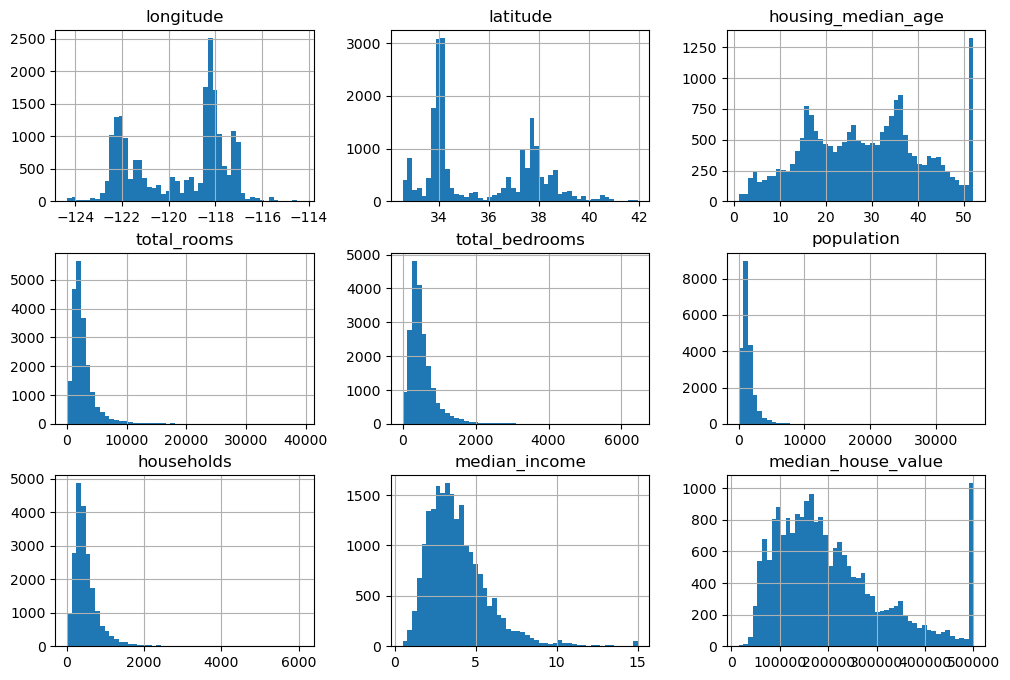

In [9]:
housing.hist(bins=50,figsize=(12,8))

<Axes: xlabel='latitude', ylabel='longitude'>

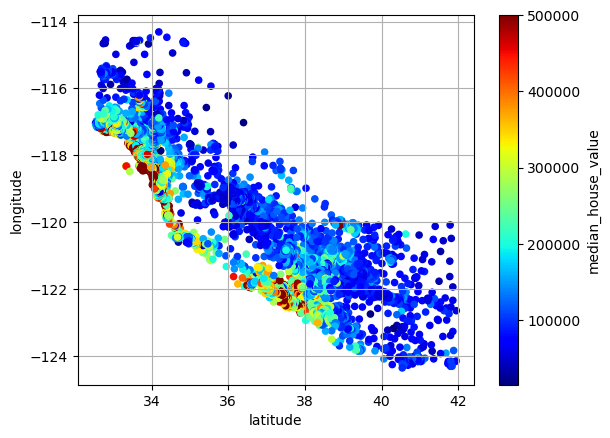

In [10]:
housing.plot(kind="scatter",y="longitude",x="latitude",grid=True,cmap="jet",c="median_house_value")

In [11]:
#building pipeline
def build_pipelines(num_attributes,cat_attributes):
    num_pipeline=Pipeline([
        ("imputer",SimpleImputer(strategy="median")),
        ("scaler",StandardScaler())
         ])
    cat_pipeline=Pipeline([
    ("onehot",OneHotEncoder(handle_unknown="ignore"))
    ])
    FullPipeline=ColumnTransformer([
    ("num",num_pipeline,num_attributes),
    ("cat",cat_pipeline,cat_attributes)
    ])
    return FullPipeline

In [12]:
if not os.path.exists(MAIN_MODEL):
#Train model
    housing=pd.read_csv("housing.csv")
    #stratified split
    housing["income_cat"]=pd.cut(housing["median_income"],
                                 bins=[0.0,1.5,3.0,4.5,6.0,np.inf],
                                 labels=[1,2,3,4,5])
    split=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
    for train_index,test_index in split.split(housing,housing["income_cat"]):
        housing.loc[test_index].drop("income_cat",axis=1).to_csv("input.csv",index=False)
        housing=housing.loc[train_index].drop("income_cat",axis=1)

    #assigning features and labels
    housing_labels=housing["median_house_value"].copy()
    housing_features=housing.drop("median_house_value",axis=1)

    num_attributes = housing_features.drop("ocean_proximity", axis=1).columns.tolist()
    cat_attributes = ["ocean_proximity"]

    pipeline=build_pipelines(num_attributes,cat_attributes)
    housing_prepared = pipeline.fit_transform(housing_features)
#INFERENCE
else:
  model=joblib.load(MAIN_MODEL)
  pipeline=joblib.load(MAIN_PIPELINE)

  input_data = pd.read_csv('input.csv')
  transformed_input = pipeline.transform(input_data)
  predictions = model.predict(transformed_input)
  input_data['median_house_value'] = predictions
  input_data.to_csv("output.csv", index=False)
  print("Inference complete! Results saved to output.csv")





                            

Inference complete! Results saved to output.csv


In [13]:
   #testing models
   #1
if not os.path.exists(MAIN_MODEL):
    lin_reg = LinearRegression()
    lin_reg.fit(housing_prepared, housing_labels)
    lin_predictions = lin_reg.predict(housing_prepared)
    lin_rmse = np.sqrt(mean_squared_error(housing_labels, lin_predictions))
    print(f"LinearRegression RMSE: {lin_rmse:.2f}")
      # 2. Decision Tree
    tree_reg = DecisionTreeRegressor(max_depth=10, min_samples_split=10, random_state=42)
    tree_reg.fit(housing_prepared, housing_labels)
    tree_predictions = tree_reg.predict(housing_prepared)
    tree_rmse = np.sqrt(mean_squared_error(housing_labels, tree_predictions))
    print(f"Decision Tree RMSE: {tree_rmse:.2f}")
       # 3. Random Forest
    # -------------------------------
    forest_reg = RandomForestRegressor(random_state=42)
    forest_reg.fit(housing_prepared, housing_labels)
    forest_predictions = forest_reg.predict(housing_prepared)
    forest_rmse = np.sqrt(mean_squared_error(housing_labels, forest_predictions))
    print(f"RandomForest RMSE: {forest_rmse:.2f}")
else:
    print("Model already exists. Skipping training and testing.")

Model already exists. Skipping training and testing.


save the best model

In [14]:
if not os.path.exists(MAIN_MODEL):
  best_model = None
  if forest_rmse <= lin_rmse and forest_rmse <= tree_rmse:
        best_model = forest_reg
        print("Best model: RandomForestRegressor")
  elif tree_rmse <= lin_rmse:
        best_model = tree_reg
        print("Best model: DecisionTreeRegressor")
  else:
        best_model = lin_reg
        print("Best model: LinearRegression")
  joblib.dump(best_model, MAIN_MODEL)
  joblib.dump(pipeline, MAIN_PIPELINE)
  print("Best model and pipeline saved!")
else:
    print("Model already exists. Skipping saving.")

Model already exists. Skipping saving.
